In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import scipy as stats
import seaborn as sns 

%matplotlib inline 
%config Completer.use_jedi = False

In [2]:
ppv = pd.read_csv('ppv_data.csv')
ppv_filtered = ppv[ppv['Ntot'] != 0]

In [3]:
def fit_model(img_subset):
    j_img_trials = []
    total_trials = []
    for value in sorted(img_subset.dv.unique()):
        j_img_trials.append(img_subset[img_subset['dv'] == value].Nimg.sum())
        total_trials.append(img_subset[img_subset['dv'] == value].Ntot.sum())
    dv_proportion = pd.DataFrame({'dv': sorted(img_subset.dv.unique()), 
                                  'Jimg': j_img_trials, 
                                  'Total':total_trials,
                                 'Proportion':(np.array(j_img_trials)/np.array(total_trials))}) 
    glm_binom = sm.GLM(pd.DataFrame({'Success': dv_proportion.Jimg, 'Failure':(dv_proportion.Total - dv_proportion.Jimg)})
                   , sm.add_constant(dv_proportion.dv, prepend = False), family = sm.families.Binomial()) 
    try: 
        res = glm_binom.fit() 
        test_dv = np.arange(dv_proportion.dv.min(), dv_proportion.dv.max(), 10)
        pred = res.get_prediction(sm.add_constant(test_dv, prepend = False))
    except:
        return None
    
    Vimage = res.params.const/res.params.dv
    if abs(Vimage) < 1000: return Vimage

In [4]:
outputs = ppv_filtered.groupby(by = ['piccat', 'session']).apply(fit_model).reset_index(name = 'Vimage')

/Users/kbw29/.pyenv/versions/Quantitative_Neurobiology/lib/python3.10/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/Users/kbw29/.pyenv/versions/Quantitative_Neurobiology/lib/python3.10/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


In [5]:
outputs

,piccat,session,Vimage
0,1,1,-11.266769
1,1,2,13.133317
2,1,3,-16.439940
3,1,4,-18.917646
4,1,5,5.768114
...,...,...,...
788,4,202,21.317381
789,4,203,20.120622
790,4,204,1.912380
791,4,205,15.534830


<AxesSubplot:xlabel='piccat', ylabel='Vimage'>

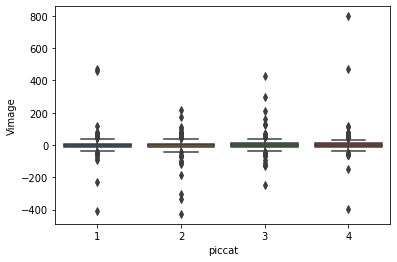

In [6]:
sns.boxplot(x = 'piccat', y = 'Vimage', data = outputs)